# Ventilation Pressure Prediction

### Introduction

kaggle: https://www.kaggle.com/c/ventilator-pressure-prediction/overview

In this competition, you’ll simulate a ventilator connected to a sedated patient's lung. The best submissions will take lung attributes **compliance and resistance** into account.

**Compliance**: Compliance is volume divided by change in pressure

**Resistance**: Resistance is the change in pressure divided by flow

### Evaluation

The competition will be scored as the mean absolute error between the predicted and actual pressures during the inspiratory phase of each breath. The expiratory phase is not scored. The score is given by:

                |𝑋−𝑌|
                
where 𝑋 is the vector of predicted pressure and 𝑌 is the vector of actual pressures across all breaths in the test set.

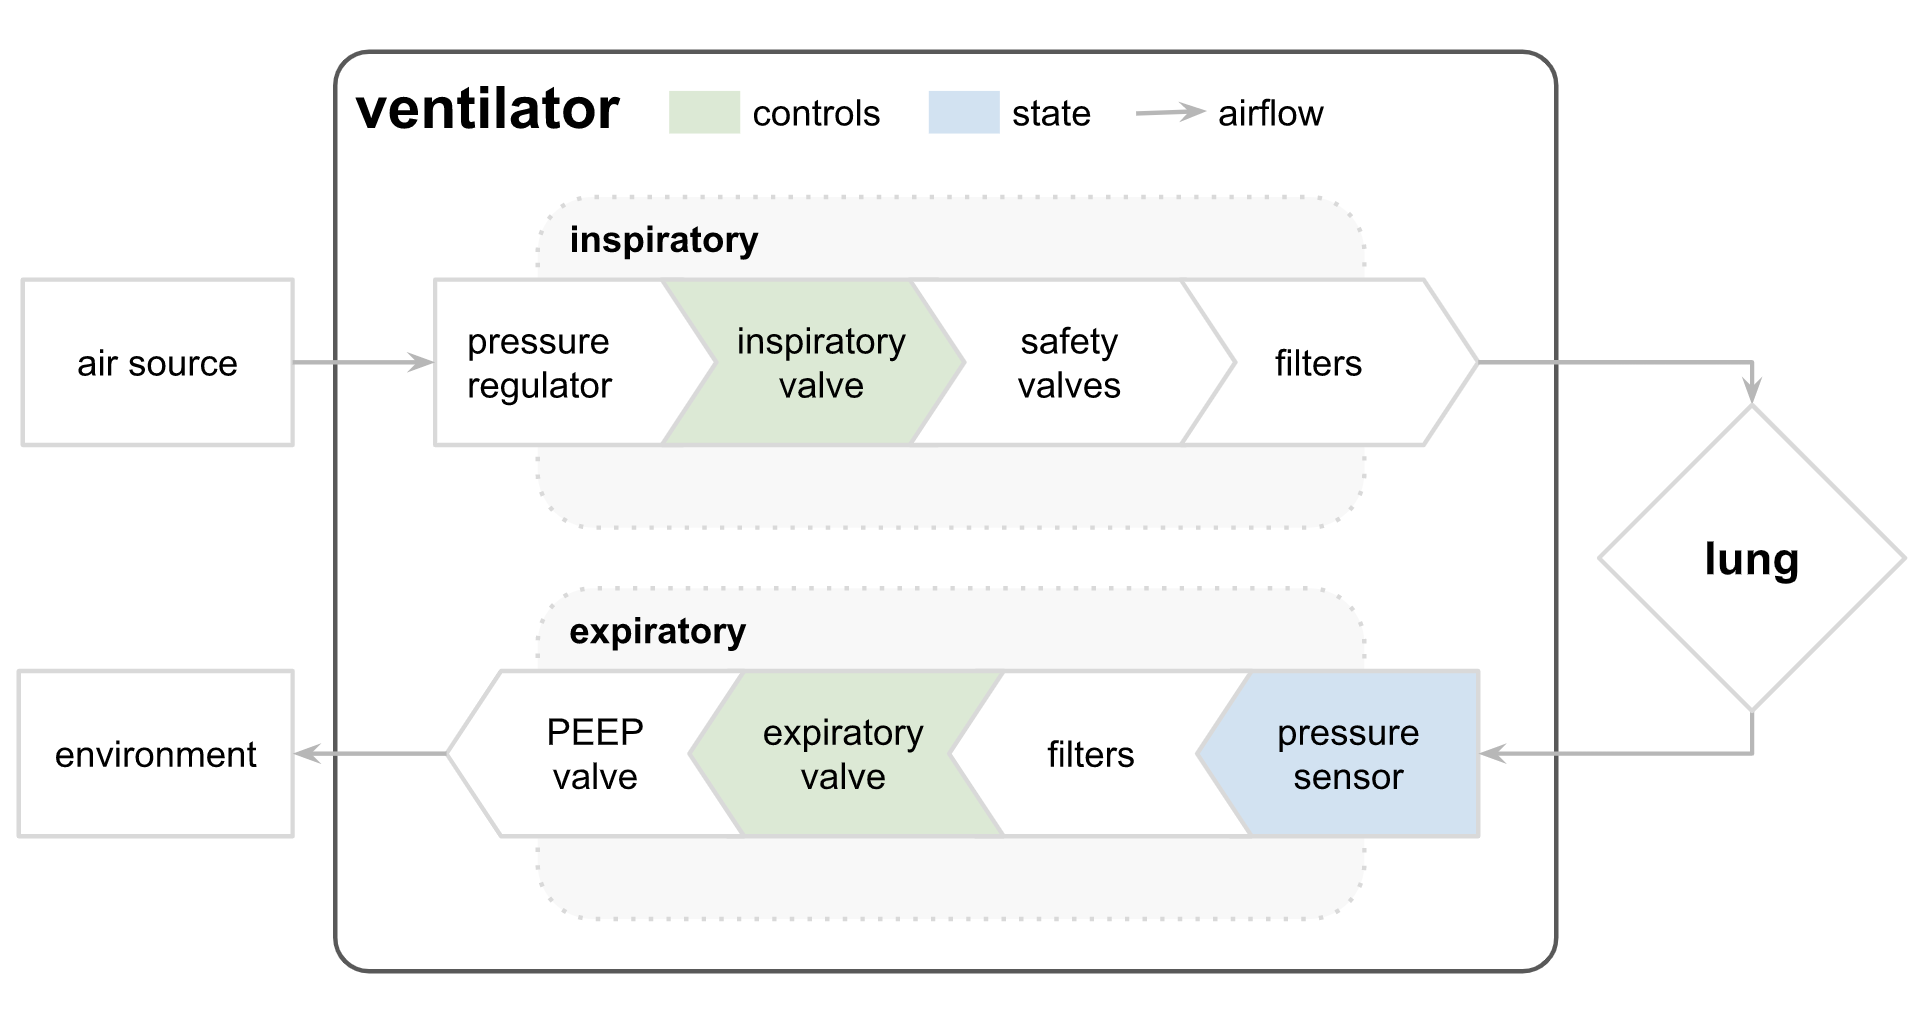

### Variables Description

   - **id** - globally-unique time step identifier across an entire file
    
   - **breath_id** - globally-unique time step for breaths
   - **R** - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
   - **C** - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
   - **time_step** - the actual time stamp.
   - **u_in(%)** - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.The first control input is a continuous variable from 0 to 100 representing the percentage the inspiratory solenoid valve is open to let air into the lung (i.e., 0 is completely closed and no air is let in and 100 is completely open).
   - **u_out** - the control input for the exploratory solenoid valve. Either 0 or 1. The second control input is a binary variable representing whether the exploratory valve is open (1) or closed (0) to let air out.
   - **pressure** - the airway pressure measured in the respiratory circuit, measured in cmH2O.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import plotly.graph_objects as go


%matplotlib inline

## Read Data

In [ ]:
train = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/train.csv')
print('Train shape: ', train.shape)
test = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')
print('Test shape: ', test.shape)
submisison = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/sample_submission.csv')

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
train.dtypes

In [ ]:
train['breath_id'].value_counts()

In [ ]:
train[train['breath_id']==1]['time_step'].value_counts()

- All the breath id have same counts i.e. 80.
- Every breath id have unique timestamps. Every breath id contain 80 different timestamps

## EDA

In [ ]:
eda_columns = ['breath_id','R','C','time_step', 'u_in','u_out','pressure']

In [ ]:
train[eda_columns].hist(figsize = (12,10))
plt.show()

Variable **'R'**, **'C'** and **'u_out'** are categorical variables here as we can see in above graphs.

In [ ]:
fig = go.Figure()
for id_ in list(set(train['breath_id']))[:10]:
    fig.add_trace(go.Scatter(x=train[train['breath_id']==id_]['time_step'], y=train[train['breath_id']==id_]['pressure'],
                        mode='lines',
                        name=str(id_)))
    
fig.update_layout(title='Pressure v/s Timestamp',
                   xaxis_title='Timestamp',
                   yaxis_title='Pressure')

fig.show()

In [ ]:
fig = go.Figure()
for id_ in list(set(train['breath_id']))[:10]:
    fig.add_trace(go.Scatter(x=train[train['breath_id']==id_]['time_step'], y=train[train['breath_id']==id_]['u_in'],
                        mode='lines',
                        name=str(id_)))
    
fig.update_layout(title='u_in v/s timestamp',
                   xaxis_title='Timestamp',
                   yaxis_title='u_in')

fig.show()

In [ ]:
fig = go.Figure()
for id_ in list(set(train['breath_id']))[:10]:
    fig.add_trace(go.Scatter(x=train[train['breath_id']==id_]['time_step'], y=train[train['breath_id']==id_]['u_out'],
                        mode='lines',
                        name=str(id_)))
    
fig.update_layout(title='u_out v/s timestamp',
                   xaxis_title='Timestamp',
                   yaxis_title='u_out')

fig.show()

In [ ]:
corr_matrix = train[eda_columns].corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, annot=True)

As we can see from above correlation plot, **Pressure** is highly correlated with **u_out** and **time_steps**.

## Train Test Split

In [ ]:
## Train test Split
inp_col = ['breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out']
out_col = ['pressure']
x_train, x_test, y_train, y_test = train_test_split(train[inp_col], train[out_col])

In [ ]:
x_train.shape

In [ ]:
y_train.shape

## ML Models

## Linear Regression

In [ ]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

In [ ]:
linear_pred = linear_model.predict(x_test)
mean_absolute_error(y_test, linear_pred)

## XGBoost Regressor

In [ ]:
%%time
xgb_model = XGBRegressor(objective ='reg:linear',n_estimators = 10)
xgb_model.fit(x_train,y_train)

In [ ]:
xgboost_pred = xgb_model.predict(x_test) 
mean_absolute_error(y_test, xgboost_pred)